In [4]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [5]:


from tensorflow.keras.datasets import mnist
from carbontracker.tracker import CarbonTracker
from sklearn.model_selection import train_test_split

# Télécharger et sauvegarder le dataset MNIST
## 60K for training and 10K for testing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train,x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 42,test_size=0.10)

x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

max_epochs=10
model= Sequential()
model.add(Dense(10, input_dim=784,activation='relu')) # First hidden layer
model.add(Dense(10,activation='softmax')) # output with 10 categories
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


c:\Users\mvana\anaconda3\envs\ML_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Initialize the tracker with the total number of epochs

tracker = CarbonTracker(epochs=max_epochs,verbose=1,
                        log_dir="./my_log_directory/",
                        sim_cpu="Intel(R) Core(TM) Ultra 7 155H",
                        sim_cpu_tdp=115,
                        sim_cpu_util=0.7,
                        sim_gpu="Intel® Arc™ graphics",
                        sim_gpu_watts=28, ### entre 4.6 et 4.8 TFLOP/sec, TGP (total Graphic Power) 28 W https://nanoreview.net/en/gpu/intel-arc-igpu-8-cores
                        sim_gpu_util=0.7
                        )

# Training loop.
for epoch in range(max_epochs):
    tracker.epoch_start()

# on entraine le modèle    
    model.fit(x_train, y_train,
          validation_split=0.1)
    
    tracker.epoch_end()

# Optional: Ensure actual consumption is reported if training stops early
tracker.stop()




Using simulated GPU: Intel® Arc™ graphics with power consumption: 19.60W (at 70% utilization)CarbonTracker: WARNING - No API keys provided. Skipping intensity provider initialization.

Using simulated CPU: Intel(R) Core(TM) Ultra 7 155H with TDP: 80.50W (at 70% utilization)
CarbonTracker: The following components were found: GPU with device(s) Intel® Arc™ graphics. CPU with device(s) Intel(R) Core(TM) Ultra 7 155H.


CarbonTracker: WARNING - No carbon intensity provider specified. Using average carbon intensity for FR: 44.18 gCO2eq/kWh.
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7505 - loss: 0.7212 - val_accuracy: 0.8083 - val_loss: 0.5372
CarbonTracker: 
Predicted consumption for 10 epoch(s):
	Time:	0:00:43
	Energy:	0.001899972938 kWh
	CO2eq:	0.083939065906 g
	This is equivalent to:
	0.000785946310 km travelled by car
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8338 - loss: 0.4767 - val_accuracy: 0.8369 - val_loss: 0.4710
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8473 - loss: 0.4416 - val_accuracy: 0.8478 - val_loss: 0.4431
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8528 - loss: 0.4210 - val_accuracy: 0.8476 - val_loss: 0.4356
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8574 - loss: 0.4090 - val_accuracy: 0.8491 - val_loss: 0.4313
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8598 - loss: 0.3988 - val_accuracy: 0.8524 

In [7]:
from carbontracker import parser

parser.print_aggregate(log_dir="./my_log_directory/")
logs = parser.parse_all_logs(log_dir="./my_log_directory/")
first_log = logs[0]

print(f"Output file name: {first_log['output_filename']}")
print(f"Standard file name: {first_log['standard_filename']}")
print(f"Stopped early: {first_log['early_stop']}")
print(f"Measured consumption: {first_log['actual']}")
print(f"Predicted consumption: {first_log['pred']}")
print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")

The training of models in this work is estimated to use 0.0031285145090000 kWh of electricity contributing to 0.0001382149083780 kg of CO2eq. This is equivalent to 0.0012941470820000 km travelled by car. Measured by carbontracker (https://github.com/lfwa/carbontracker).
Output file name: ./my_log_directory/17808.455397_2025-11-26T094340Z_carbontracker_output.log
Standard file name: ./my_log_directory/17808.455397_2025-11-26T094340Z_carbontracker.log
Stopped early: False
Measured consumption: {'epochs': 1, 'duration (s)': 56.0, 'energy (kWh)': 0.002450397526, 'co2eq (g)': 0.108256320595, 'equivalents': {'km travelled by car': 0.001013635961}}
Predicted consumption: {'epochs': 10, 'duration (s)': 43.0, 'energy (kWh)': 0.001899972938, 'co2eq (g)': 0.083939065906, 'equivalents': {'km travelled by car': 0.00078594631}}
Measured GPU devices: ['Intel® Arc™ graphics']


In [8]:
import psutil
from threading import Thread

max_epochs = 50
epoch_cpu_means = []

for epoch in range(max_epochs):
    cpu_usage = []

    def monitor_cpu(stop_flag):
        while not stop_flag["stop"]:
            cpu_usage.append(psutil.cpu_percent(interval=0.1))  # toutes les 0.1 s

    stop_flag = {"stop": False}
    monitor_thread = Thread(target=monitor_cpu, args=(stop_flag,))
    monitor_thread.start()

    # ====== Entraînement pour 1 epoch ======
    print(f"\n===== Epoch {epoch+1}/{max_epochs} =====")
    model.fit(
        x_train, y_train,
        epochs=1,
        validation_split=0.1,
        verbose=1
    )

    # ====== Fin du monitoring CPU ======
    stop_flag["stop"] = True
    monitor_thread.join()

    if cpu_usage:  # éviter division par zéro
        avg_cpu = sum(cpu_usage) / len(cpu_usage)
    else:
        avg_cpu = 0.0

    epoch_cpu_means.append(avg_cpu)
    print(f"CPU moyen pendant l'epoch {epoch+1} : {avg_cpu:.2f} %")

print("\nCPU moyen par epoch :", epoch_cpu_means)
print("CPU moyen global :", sum(epoch_cpu_means) / len(epoch_cpu_means), "%")


===== Epoch 1/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8698 - loss: 0.3666 - val_accuracy: 0.8563 - val_loss: 0.4046
CPU moyen pendant l'epoch 1 : 14.55 %

===== Epoch 2/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8721 - loss: 0.3608 - val_accuracy: 0.8624 - val_loss: 0.3893
CPU moyen pendant l'epoch 2 : 18.32 %

===== Epoch 3/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8721 - loss: 0.3585 - val_accuracy: 0.8646 - val_loss: 0.3864
CPU moyen pendant l'epoch 3 : 17.35 %

===== Epoch 4/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8740 - loss: 0.3556 - val_accuracy: 0.8630 - val_loss: 0.3830
CPU moyen pendant l'epoch 4 : 12.88 %

===== Epoch 5/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8745 - loss: 0.3518 - val_accuracy: 0.8572 - val_loss: 0.3953
CPU moyen pendant l'epoch 5 : 15.90 %

===== Epoch 6/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8755 - loss: 0

In [73]:
import time
import psutil
from threading import Thread
import pandas as pd
from carbontracker.tracker import CarbonTracker

def train_with_carbontracker(
    model,
    x_train,
    y_train,
    epochs=100,
    val_split=0.1,
    verbose=1,
    # paramètres pour CarbonTracker (simulation)
    cpu_tdp=115,      # W, puissance max CPU
    gpu_tgp=28,       # W, puissance max GPU
    sim_cpu="Intel(R) Core(TM) Ultra 7 155H",
    sim_gpu="Intel® Arc™ graphics",
    sim_cpu_util=0.20,   # hypothèse d'utilisation CPU pour CarbonTracker (20%)
    sim_gpu_util=0.1,   # hypothèse d'utilisation GPU (scénario "plausible") => quasiment inactif, pas utilisé par keras
    log_dir="./my_log_plausible/"
):
    """
    Entraîne le modèle epoch par epoch en:
      - mesurant le CPU moyen à chaque epoch avec psutil,
      - utilisant CarbonTracker pour estimer énergie/CO2
        (avec des hypothèses sim_cpu/sim_gpu constantes).

    Retourne un DataFrame avec, pour chaque epoch:
      - cpu_mean_percent, duration_s, train_loss, train_acc, val_loss, val_acc
    """

    # ---------- 1) Initialisation de CarbonTracker ----------
    tracker = CarbonTracker(
        epochs=epochs,
        verbose=1,
        log_dir=log_dir,
        sim_cpu=sim_cpu,
        sim_cpu_tdp=cpu_tdp,
        sim_cpu_util=sim_cpu_util,  # constante pour le modèle de CarbonTracker
        sim_gpu=sim_gpu,
        sim_gpu_watts=gpu_tgp,
        sim_gpu_util=sim_gpu_util   # scénario GPU "plausible"
    )

    # Pour stocker les infos par epoch
    epoch_cpu_means = []
    epoch_durations = []
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_val_loss = []
    epoch_val_acc = []

    # ---------- 2) Boucle d'entraînement epoch par epoch ----------
    for epoch in range(epochs):
        print(f"\n===== Epoch {epoch+1}/{epochs} =====")

        # --- 2.1 Début de l'epoch pour CarbonTracker ---
        tracker.epoch_start()

        # --- 2.2 Monitoring CPU pendant cette epoch ---
        cpu_usage = []

        def monitor_cpu(stop_flag):
            while not stop_flag["stop"]:
                cpu_usage.append(psutil.cpu_percent(interval=0.1))  # toutes les 0.1 s

        stop_flag = {"stop": False}
        monitor_thread = Thread(target=monitor_cpu, args=(stop_flag,))
        monitor_thread.start()

        # --- 2.3 Entraînement pour 1 epoch ---
        start = time.time()
        history = model.fit(
            x_train, y_train,
            epochs=1,
            validation_split=val_split,
            verbose=verbose
        )
        end = time.time()

        # --- 2.4 Fin du monitoring CPU ---
        stop_flag["stop"] = True
        monitor_thread.join()

        # moyenne CPU sur cette epoch
        if cpu_usage:  # éviter division par zéro
            avg_cpu = sum(cpu_usage) / len(cpu_usage)
        else:
            avg_cpu = 0.0

        duration_s = end - start

        epoch_cpu_means.append(avg_cpu)
        epoch_durations.append(duration_s)

        # récupérer les métriques Keras de cette epoch
        # history.history['loss'] est une liste de taille 1 (car epochs=1)
        train_loss = history.history['loss'][0]
        train_acc  = history.history.get('accuracy', [None])[0]
        val_loss   = history.history.get('val_loss', [None])[0]
        val_acc    = history.history.get('val_accuracy', [None])[0]

        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)

        print(f"CPU moyen pendant l'epoch : {avg_cpu:.2f} %")
        print(f"Durée de l'epoch : {duration_s:.1f} s")
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
              f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        # --- 2.5 Fin de l'epoch pour CarbonTracker ---
        tracker.epoch_end()

    # ---------- 3) Fin du tracking CarbonTracker ----------
    tracker.stop()

    # ---------- 4) DataFrame récapitulatif ----------
    df = pd.DataFrame({
        "epoch": list(range(1, epochs+1)),
        "cpu_mean_percent": epoch_cpu_means,
        "duration_s": epoch_durations,
        "train_loss": epoch_train_loss,
        "train_acc": epoch_train_acc,
        "val_loss": epoch_val_loss,
        "val_acc": epoch_val_acc,
    })

    return df


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import Input

def build_model(input_dim=None, complexity="Model1"):
    model = Sequential()
    
    # Model 1 = "small"
    if complexity == "Model1":
        model.add(Dense(32, input_dim=input_dim, activation='relu'))
        model.add(Dense(10, activation='softmax'))
    
    # Model 2 = "small + 1 Dense"
    elif complexity == "Model2":
        model.add(Dense(128, input_dim=input_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(10, activation='softmax')) 
        
    # Model 3 = "small + 2 Dense"    
    elif complexity == "Model3":
        model.add(Dense(256, input_dim=input_dim, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        
    # Model 4 = "small + Conv + MaxPool + Flatten"
    elif complexity == "Model4":
        model.add(Input(shape=(28,28,1)))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')) 
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        # ici PAS de input_dim, Keras le déduit après Flatten
        model.add(Dense(32, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    # Model 5 = "small + 2Conv + MaxPool + Flatten"
    elif complexity == "Model5":
        model.add(Input(shape=(28,28,1)))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')) 
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(49, activation='relu'))  # 7x7 après deux maxpool
        model.add(Dense(10, activation='softmax'))
    
    # Model 6 = Model5 + Dropout
    elif complexity == "Model6":
        model.add(Input(shape=(28,28,1)))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')) 
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(49, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(10, activation='softmax'))
 
    # Model 7 = CNN + BatchNorm + GlobalAveragePooling
    elif complexity == "Model7":
        model.add(Input(shape=(28,28,1)))
        model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=96, kernel_size=3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(0.4))
        model.add(Dense(10, activation='softmax'))
 
    else:
        raise ValueError("Unknown complexity level")

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [75]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

# normalisation
x_train_raw = x_train_raw.astype("float32") / 255.0
x_test_raw  = x_test_raw.astype("float32") / 255.0

# split train / val
x_train_raw, x_val_raw, y_train_raw, y_val_raw = train_test_split(
    x_train_raw, y_train_raw, test_size=0.1, random_state=42
)

# ---------- Version MLP : flatten ----------
x_train_flat = x_train_raw.reshape((x_train_raw.shape[0], -1))
x_val_flat   = x_val_raw.reshape((x_val_raw.shape[0], -1))
x_test_flat  = x_test_raw.reshape((x_test_raw.shape[0], -1))

input_dim_flat = x_train_flat.shape[1]  # = 784

# ---------- Version CNN : (28, 28, 1) ----------
x_train_cnn = np.expand_dims(x_train_raw, axis=-1)  # (N, 28, 28, 1)
x_val_cnn   = np.expand_dims(x_val_raw, axis=-1)
x_test_cnn  = np.expand_dims(x_test_raw, axis=-1)

# one-hot
y_train = to_categorical(y_train_raw, 10)
y_val   = to_categorical(y_val_raw, 10)
y_test  = to_categorical(y_test_raw, 10)


In [76]:
def run_experiment(
    complexity,
    epochs=100,
    val_split=None,  
    sim_cpu_util=0.16,
    sim_gpu_util=0.1,
    log_dir_prefix="./logs_"
):
    # Choix des données et de input_dim selon le modèle
    if complexity in ["Model1", "Model2", "Model3"]:
        x_train_used = x_train_flat
        x_test_used  = x_test_flat
        input_dim = input_dim_flat
    else:
        x_train_used = x_train_cnn
        x_test_used  = x_test_cnn
        input_dim = None  # ignoré dans build_model pour les CNN

    model = build_model(input_dim=input_dim, complexity=complexity)

    log_dir = f"{log_dir_prefix}{complexity}/"

    # ici, version de train_with_carbontracker qui utilise validation_split
    df_epochs = train_with_carbontracker(
        model,
        x_train_used,
        y_train,
        epochs=epochs,
        val_split=0.1,       # tu peux le garder
        verbose=1,
        sim_cpu_util=sim_cpu_util,
        sim_gpu_util=sim_gpu_util,
        log_dir=log_dir
    )

    test_loss, test_acc = model.evaluate(x_test_used, y_test, verbose=0)
    print(f"[{complexity}] Test accuracy: {test_acc:.4f}")

    return df_epochs, test_acc


In [91]:
results = {}

for complexity in ["Model1", "Model2", "Model3", "Model4", "Model5", "Model6", "Model7"]:
    print(f"\n########## EXPÉRIENCE : {complexity} ##########")
    df_epochs, test_acc = run_experiment(
        complexity,
        epochs=50,
        sim_cpu_util=0.16,
        sim_gpu_util=0.5
    )
    results[complexity] = {
        "df_epochs": df_epochs,
        "test_acc": test_acc
    }


########## EXPÉRIENCE : Model1 ##########
Using simulated GPU: Intel® Arc™ graphics with power consumption: 14.00W (at 50% utilization)
Using simulated CPU: Intel(R) Core(TM) Ultra 7 155H with TDP: 18.40W (at 16% utilization)
CarbonTracker: The following components were found: GPU with device(s) Intel® Arc™ graphics. CPU with device(s) Intel(R) Core(TM) Ultra 7 155H.
CarbonTracker: WARNING - No API keys provided. Skipping intensity provider initialization.


c:\Users\mvana\anaconda3\envs\ML_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CarbonTracker: WARNING - No carbon intensity provider specified. Using average carbon intensity for FR: 44.18 gCO2eq/kWh.

===== Epoch 1/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8094 - loss: 0.5595 - val_accuracy: 0.8176 - val_loss: 0.5091
CPU moyen pendant l'epoch : 14.47 %
Durée de l'epoch : 4.6 s
Train loss: 0.5595, Train acc: 0.8094, Val loss: 0.5091, Val acc: 0.8176
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:03:53
	Energy:	0.003318581834 kWh
	CO2eq:	0.146611908927 g
	This is equivalent to:
	0.001372770683 km travelled by car

===== Epoch 2/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8511 - loss: 0.4244 - val_accuracy: 0.8496 - val_loss: 0.4236
CPU moyen pendant l'epoch : 14.01 %
Durée de l'epoch : 3.9 s
Train loss: 0.4244, Train acc: 0.8511, Val loss: 0.4236, Val acc: 0.8496

===== Epoch 3/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8616 - loss: 0.3901 - val_accuracy: 0.8635 - val_loss: 0.386

c:\Users\mvana\anaconda3\envs\ML_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CarbonTracker: WARNING - No carbon intensity provider specified. Using average carbon intensity for FR: 44.18 gCO2eq/kWh.

===== Epoch 1/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8186 - loss: 0.5153 - val_accuracy: 0.8450 - val_loss: 0.4316
CPU moyen pendant l'epoch : 16.80 %
Durée de l'epoch : 5.1 s
Train loss: 0.5153, Train acc: 0.8186, Val loss: 0.4316, Val acc: 0.8450
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:04:19
	Energy:	0.003684258873 kWh
	CO2eq:	0.162767185922 g
	This is equivalent to:
	0.001524037321 km travelled by car

===== Epoch 2/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8633 - loss: 0.3768 - val_accuracy: 0.8570 - val_loss: 0.4028
CPU moyen pendant l'epoch : 16.49 %
Durée de l'epoch : 5.0 s
Train loss: 0.3768, Train acc: 0.8633, Val loss: 0.4028, Val acc: 0.8570

===== Epoch 3/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8768 - loss: 0.3407 - val_accuracy: 0.8678 - val_loss: 0.352

c:\Users\mvana\anaconda3\envs\ML_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CarbonTracker: WARNING - No carbon intensity provider specified. Using average carbon intensity for FR: 44.18 gCO2eq/kWh.

===== Epoch 1/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8187 - loss: 0.5057 - val_accuracy: 0.8513 - val_loss: 0.4003
CPU moyen pendant l'epoch : 17.17 %
Durée de l'epoch : 14.5 s
Train loss: 0.5057, Train acc: 0.8187, Val loss: 0.4003, Val acc: 0.8513
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:12:09
	Energy:	0.010372724237 kWh
	CO2eq:	0.458257465746 g
	This is equivalent to:
	0.004290800241 km travelled by car

===== Epoch 2/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8628 - loss: 0.3742 - val_accuracy: 0.8557 - val_loss: 0.4016
CPU moyen pendant l'epoch : 18.18 %
Durée de l'epoch : 11.6 s
Train loss: 0.3742, Train acc: 0.8628, Val loss: 0.4016, Val acc: 0.8557

===== Epoch 3/50 =====
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8767 - loss: 0.3371 - val_accuracy: 0.8763 - val_loss: 0

In [107]:
import pickle
# Supposons que 'model' est votre modèle entraîné
with open('modelCarbonTracker.pkl', 'wb') as fichier:
    pickle.dump(results, fichier)

In [108]:
results

{'Model1': {'df_epochs':     epoch  cpu_mean_percent  duration_s  ...  train_acc  val_loss   val_acc
  0       1         14.469565    4.621373  ...   0.809362  0.509059  0.817593
  1       2         14.007692    3.912666  ...   0.851091  0.423598  0.849630
  2       3         19.251429    3.468048  ...   0.861625  0.386175  0.863519
  3       4         21.896774    3.104507  ...   0.870103  0.388740  0.857407
  4       5         18.658621    2.905817  ...   0.875165  0.380377  0.858889
  5       6         20.403125    3.157429  ...   0.878313  0.364408  0.865556
  6       7         14.640625    3.184971  ...   0.883601  0.363940  0.867778
  7       8         16.978125    3.164845  ...   0.885658  0.361743  0.868704
  8       9         13.843902    4.147954  ...   0.888230  0.357411  0.869630
  9      10         12.512245    4.956317  ...   0.889856  0.336999  0.878519
  10     11         13.577500    3.957937  ...   0.891379  0.375226  0.864630
  11     12         17.522222    3.616109

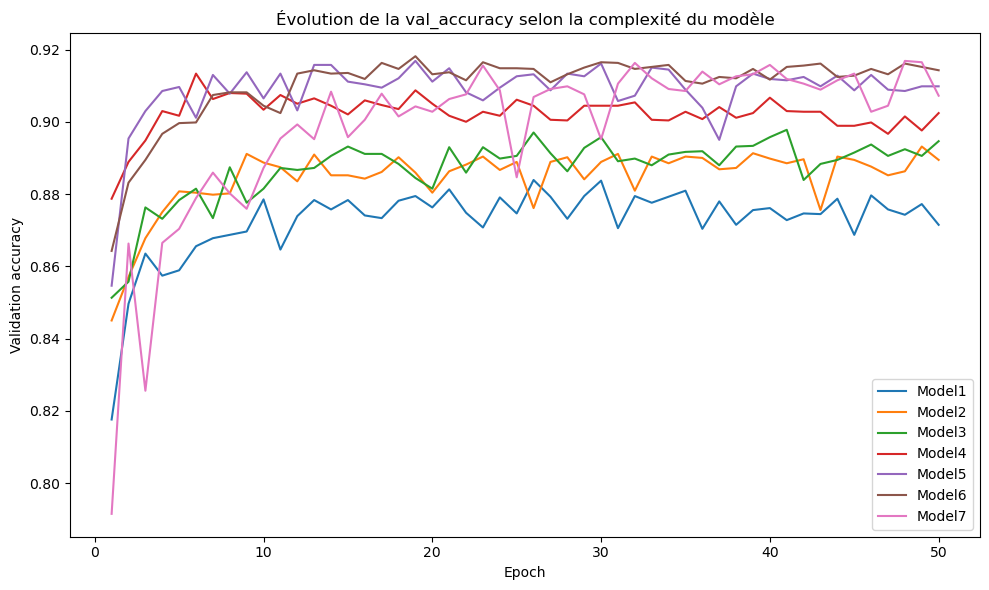

In [ ]:
import matplotlib.pyplot as plt

# 1) Courbes de val_acc par epoch
plt.figure(figsize=(10, 6))

for complexity, res in results.items():
    df = res["df_epochs"]
    plt.plot(df["epoch"], df["val_acc"], marker="", label=complexity)

plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Évolution de la val_accuracy selon la complexité du modèle")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig("streamlit/val_accuracy_par_modele.png", dpi=300)   # image haute résolution

plt.show()


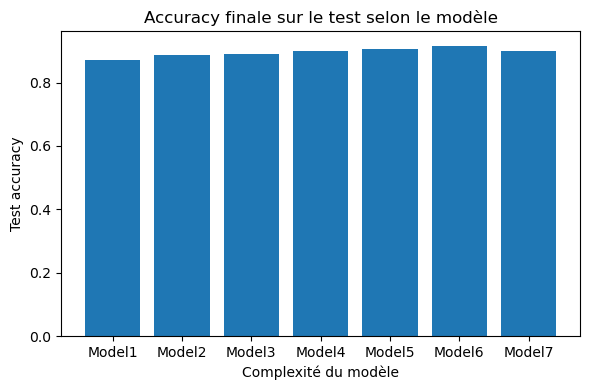

In [119]:
models = []
test_accs = []

for complexity, res in results.items():
    models.append(complexity)
    test_accs.append(res["test_acc"])

plt.figure(figsize=(6, 4))
plt.bar(models, test_accs)
plt.xlabel("Complexité du modèle")
plt.ylabel("Test accuracy")
plt.title("Accuracy finale sur le test selon le modèle")
plt.tight_layout()
plt.show()


In [120]:
df_Model1   = results["Model1"]["df_epochs"]
acc_Model1 = results["Model1"]["test_acc"]
df_Model2   = results["Model2"]["df_epochs"]
acc_Model2 = results["Model2"]["test_acc"]
df_Model3   = results["Model3"]["df_epochs"]
acc_Model3 = results["Model3"]["test_acc"]
df_Model4   = results["Model4"]["df_epochs"]
acc_Model4 = results["Model4"]["test_acc"]
df_Model5   = results["Model5"]["df_epochs"]
acc_Model5 = results["Model5"]["test_acc"]
df_Model6   = results["Model6"]["df_epochs"]
acc_Model6 = results["Model6"]["test_acc"]
df_Model7   = results["Model7"]["df_epochs"]
acc_Model7 = results["Model7"]["test_acc"]

In [177]:
from carbontracker import parser

def get_energy_co2_from_logs(log_dir):
    logs = parser.parse_all_logs(log_dir=log_dir)
    log = logs[0]

    block = log.get("actual") or log.get("pred")

    # récupérer énergie
    energy_kWh = None
    co2_kg = None
    co2_travel_car = None

    for k, v in block.items():
        kl = k.lower()
        if "energy" in kl:
            energy_kWh = v
        elif "co2" in kl:
            # peut être g ou kg
            if "g" in kl:
                co2_kg = v / 1000
            else:
                co2_kg = v
        elif "equivalents" in kl:
            # on récupère le dictionnaire {"km travelled by car": valeur}
            if isinstance(v, dict):
                co2_travel_car = list(v.values())[0]  # 👉 récupère uniquement le nombre

    return energy_kWh, co2_kg, co2_travel_car


In [178]:
import pandas as pd

summary_rows = []

for complexity in ["Model1", "Model2", "Model3", "Model4", "Model5", "Model6", "Model7"]:
    log_dir = f"./logs_{complexity}/"
    energy_kWh, co2_kg, co2_val_travel = get_energy_co2_from_logs(log_dir)

    test_acc = results[complexity]["test_acc"]
    # temps total d'entraînement pour ce modèle
    time_s = results[complexity]["df_epochs"]["duration_s"].sum()

    summary_rows.append({
        "model": complexity,
        "test_acc": test_acc,
        "energy_kWh": energy_kWh,
        "co2_g": co2_kg*1000,
        "co2_travel_car": co2_val_travel,
        "time_s": time_s
    })

df_summary = pd.DataFrame(summary_rows)
print(df_summary)

df_summary["co2_travel_car"]

    model  test_acc  energy_kWh     co2_g  co2_travel_car       time_s
0  Model1    0.8721    0.006942  0.306698        0.002872   264.423000
1  Model2    0.8874    0.001230  0.054361        0.000509   263.203936
2  Model3    0.8913    0.006465  0.285598        0.002674   452.128475
3  Model4    0.8983    0.001279  0.056499        0.000529   601.565742
4  Model5    0.9045    0.002230  0.098502        0.000922  1753.692995
5  Model6    0.9156    0.002435  0.107564        0.001007   938.163324
6  Model7    0.8991    0.038326  1.693220        0.015854  2692.554053


0    0.002872
1    0.000509
2    0.002674
3    0.000529
4    0.000922
5    0.001007
6    0.015854
Name: co2_travel_car, dtype: float64

In [179]:
for model_name, res in results.items():
    print(model_name, res["df_epochs"]["duration_s"].sum())

Model1 264.4230000972748
Model2 263.2039358615875
Model3 452.1284747123718
Model4 601.5657424926758
Model5 1753.6929948329926
Model6 938.1633241176605
Model7 2692.5540528297424


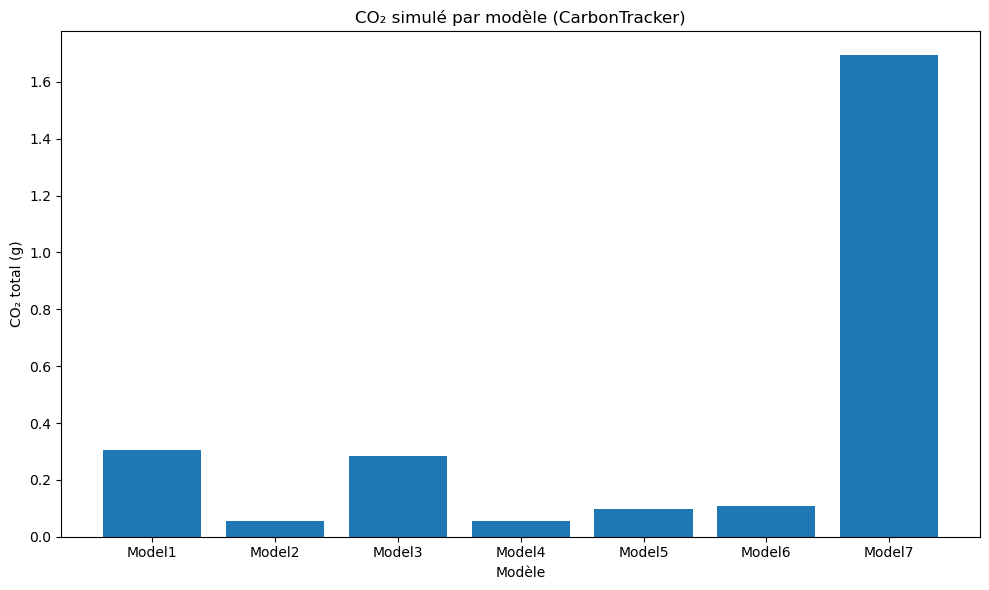

In [180]:
plt.figure(figsize=(10, 6))
plt.bar(df_summary["model"], df_summary["co2_g"])
plt.xlabel("Modèle")
plt.ylabel("CO₂ total (g)")
plt.title("CO₂ simulé par modèle (CarbonTracker)")
plt.tight_layout()
# 1) Courbes de val_acc par epoch
plt.savefig("streamlit/CO2Total_model.png", dpi=300)   # image haute résol
plt.show()

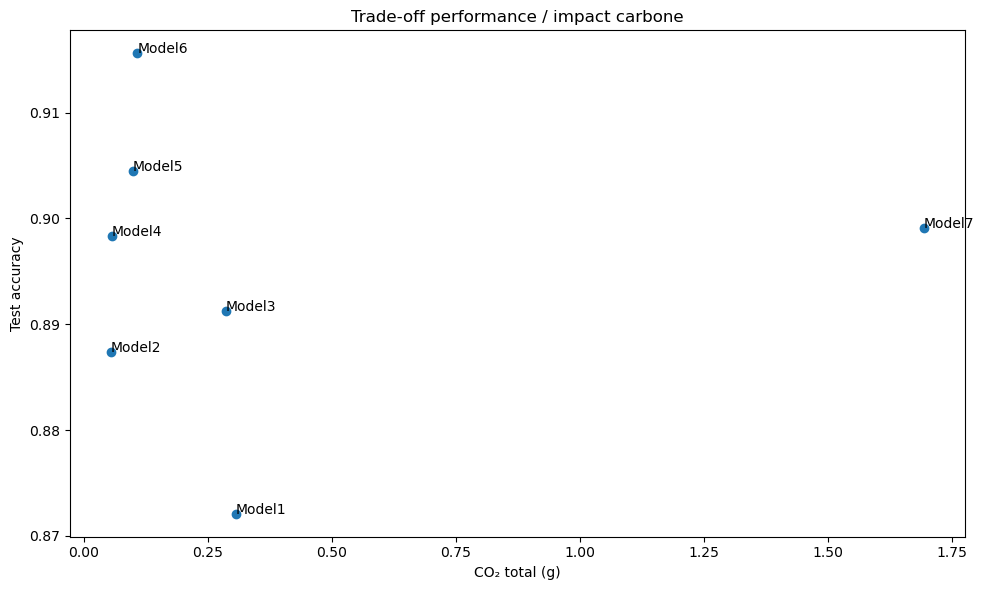

In [213]:
plt.figure(figsize=(10, 6))
plt.scatter(df_summary["co2_g"], df_summary["test_acc"])

for i, row in df_summary.iterrows():
    plt.text(row["co2_g"], row["test_acc"], row["model"])

plt.xlabel("CO₂ total (g)")
plt.ylabel("Test accuracy")
plt.title("Trade-off performance / impact carbone")
plt.tight_layout()
plt.savefig("streamlit/accuravyVSCO2Total.png", dpi=300)
plt.show()


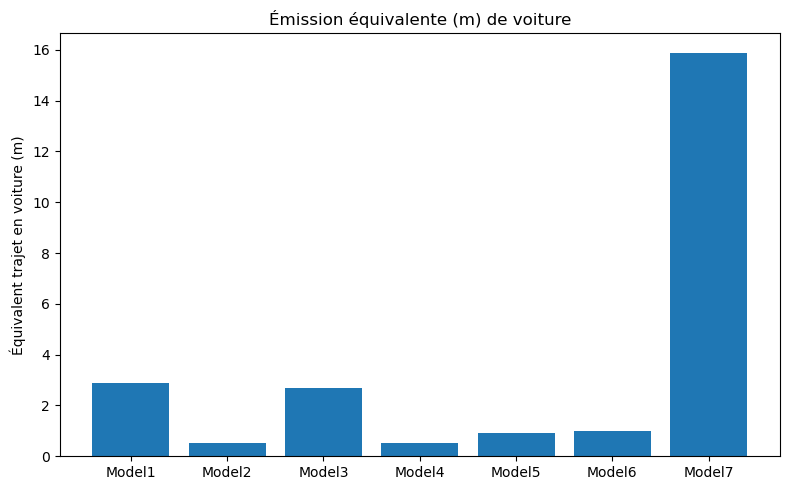

In [219]:
plt.figure(figsize=(8,5))
plt.bar(df_summary["model"], df_summary["co2_travel_car"]*1000)
plt.ylabel("Équivalent trajet en voiture (m)")
plt.title("Émission équivalente (m) de voiture")
plt.tight_layout()
plt.savefig("streamlit/CO2equivalenttrajetModel.png", dpi=300)
plt.show()


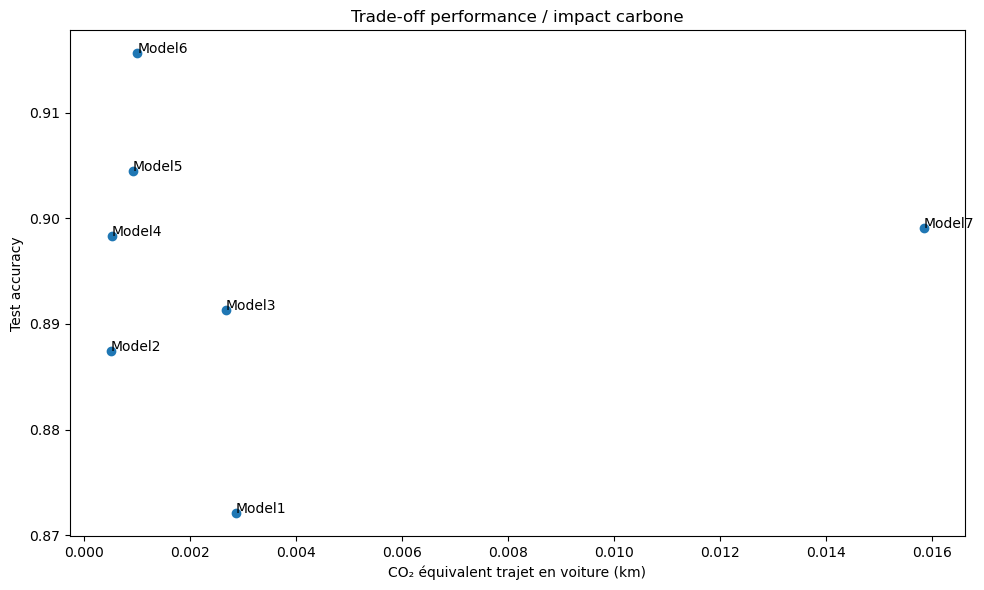

In [215]:
plt.figure(figsize=(10, 6))
plt.scatter(df_summary["co2_travel_car"], df_summary["test_acc"])

for i, row in df_summary.iterrows():
    plt.text(row["co2_travel_car"], row["test_acc"], row["model"])

plt.xlabel("CO₂ équivalent trajet en voiture (km)")
plt.ylabel("Test accuracy")
plt.title("Trade-off performance / impact carbone")
plt.tight_layout()
plt.savefig("streamlit/accuravyVSCO2travelcar.png", dpi=300)
plt.show()

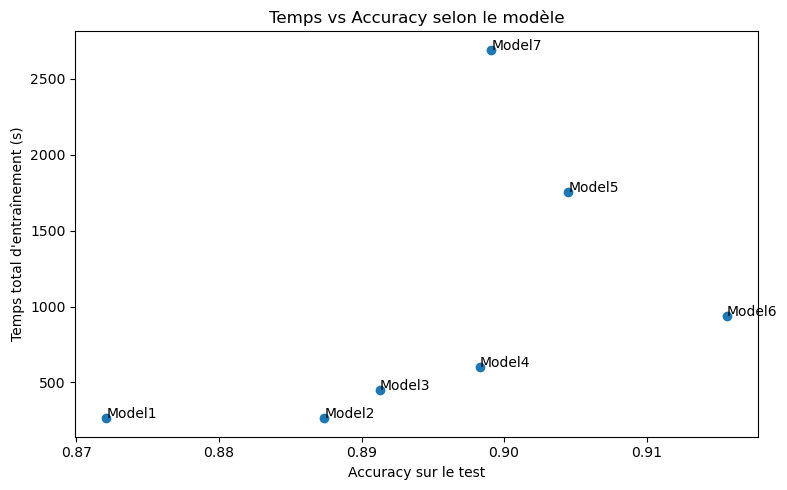

In [223]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df_summary["test_acc"], df_summary["time_s"])

for i, row in df_summary.iterrows():
    plt.text(row["test_acc"], row["time_s"], row["model"])

plt.xlabel("Accuracy sur le test")
plt.ylabel("Temps total d'entraînement (s)")
plt.title("Temps vs Accuracy selon le modèle")
plt.tight_layout()
plt.savefig("streamlit/accuravyVStime.png", dpi=300)
plt.show()


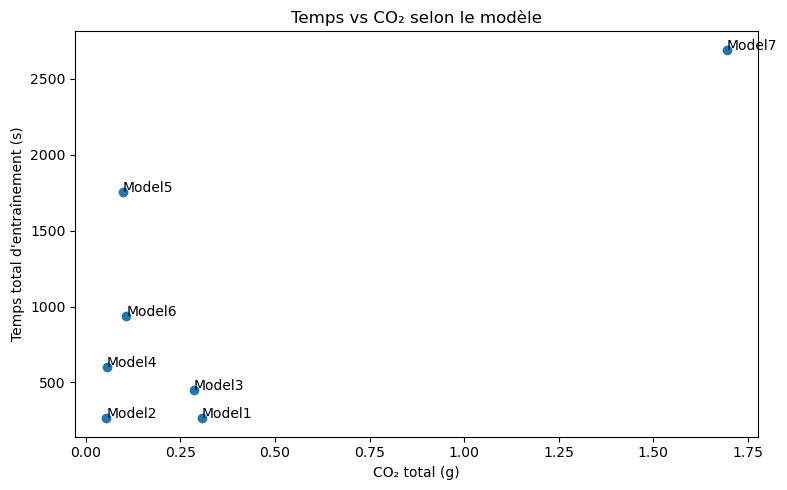

In [226]:
plt.figure(figsize=(8, 5))
plt.scatter(df_summary["co2_g"], df_summary["time_s"])

for i, row in df_summary.iterrows():
    plt.text(row["co2_g"], row["time_s"], row["model"])

plt.xlabel("CO₂ total (g)")
plt.ylabel("Temps total d'entraînement (s)")
plt.title("Temps vs CO₂ selon le modèle")
plt.tight_layout()
plt.savefig("streamlit/co2VStime.png", dpi=300)
plt.show()


In [227]:
from carbontracker import parser

logs = parser.parse_all_logs(log_dir="./logs_Model1/")
log = logs[0]

print("Clés du log :", log.keys())
print("\nBloc actual :")
print(log.get("actual"))
print("\nBloc pred :")
print(log.get("pred"))


Clés du log : dict_keys(['output_filename', 'standard_filename', 'components', 'early_stop', 'actual', 'pred'])

Bloc actual :
None

Bloc pred :
{'epochs': 100, 'duration (s)': 488.0, 'energy (kWh)': 0.006942147338, 'co2eq (g)': 0.306697717345, 'equivalents': {'km travelled by car': 0.002871701473}}
